In [1]:
# 아래를 수행하기 전에 kernel을 restart 해야 함. 
from mmdet.apis import init_detector, inference_detector
import mmcv

### PASCAL VOC형태의 BCCD Dataset를 Download 후 MS-COCO 형태로 변경
* BCCD Dataset은 백혈구(WBC), 적혈구(RBC), 혈소판(Platelets) 세가지 유형의 Object Class를 가짐.
* 다운로드 받은 Dataset은 Pascal VOC 형태이므로 이를 별도의 유틸리티를 이용하여 MS-COCO 형태로 변환 


In [2]:
!git clone https://github.com/Shenggan/BCCD_Dataset.git

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800
Receiving objects: 100% (800/800), 7.39 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (378/378), done.


### VOC를 COCO로 변환하는 package적용하기


BCCD_Dataset  
ㄴBCCD  
_ㄴJPEGImages : 이미지 파일  
_ㄴAnnotations : Ann파일 존재 (이미지당 1개씩-PASCAL VOC 특징)  
_ㄴImageSets/Main : train/val/test 별 이미지 리스트(.txt)

ImageSets안의 정보를 이용하여 train/val/test별 json파일(모든 이미지의 정보(Ann)를 포함하고 있는)을 만든다. 

In [3]:
!git clone https://github.com/yukkyo/voc2coco.git

Cloning into 'voc2coco'...
remote: Enumerating objects: 423, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 423 (delta 3), reused 10 (delta 2), pack-reused 409
Receiving objects: 100% (423/423), 214.47 KiB | 7.39 MiB/s, done.
Resolving deltas: 100% (379/379), done.


In [4]:
import os

# colab 버전은 아래 명령어로 ballnfish_classes.txt 를 수정합니다. 
with open('BCCD_Dataset/BCCD/labels.txt', "w") as f:
    f.write("WBC\n")
    f.write("RBC\n")
    f.write("Platelets\n")

!cat BCCD_Dataset/BCCD/labels.txt

WBC
RBC
Platelets


In [10]:
# VOC를 COCO로 변환 수행. 학습/검증/테스트 용 json annotation을 생성. 

!python voc2coco/voc2coco.py --ann_dir BCCD_Dataset/BCCD/Annotations \
--ann_ids BCCD_Dataset/BCCD/ImageSets/Main/train.txt \
--labels BCCD_Dataset/BCCD/labels.txt \
--output BCCD_Dataset/BCCD/train.json \
--ext xml

!python voc2coco/voc2coco.py --ann_dir BCCD_Dataset/BCCD/Annotations \
--ann_ids BCCD_Dataset/BCCD/ImageSets/Main/val.txt \
--labels BCCD_Dataset/BCCD/labels.txt \
--output BCCD_Dataset/BCCD/val.json \
--ext xml

!python voc2coco/voc2coco.py --ann_dir BCCD_Dataset/BCCD/Annotations \
--ann_ids BCCD_Dataset/BCCD/ImageSets/Main/test.txt \
--labels BCCD_Dataset/BCCD/labels.txt \
--output BCCD_Dataset/BCCD/test.json \
--ext xml

Start converting !
100%|███████████████████████████████████████| 205/205 [00:00<00:00, 9968.84it/s]
Start converting !
100%|████████████████████████████████████████| 87/87 [00:00<00:00, 10340.17it/s]
Start converting !
100%|████████████████████████████████████████| 72/72 [00:00<00:00, 10124.04it/s]


In [ ]:
!cat BCCD_Dataset/BCCD/train.json

In [29]:
!jq . BCCD_Dataset/BCCD/train.json > output.json
!tail -100 output.json

      "category_id": 2,
      "ignore": 0,
      "segmentation": [],
      "image_id": "BloodImage_00408",
      "id": 2800
    },
    {
      "area": 9405,
      "iscrowd": 0,
      "bbox": [
        102,
        0,
        99,
        95
      ],
      "category_id": 2,
      "ignore": 0,
      "segmentation": [],
      "image_id": "BloodImage_00408",
      "id": 2801
    },
    {
      "area": 7128,
      "iscrowd": 0,
      "bbox": [
        197,
        0,
        88,
        81
      ],
      "category_id": 2,
      "ignore": 0,
      "segmentation": [],
      "image_id": "BloodImage_00408",
      "id": 2802
    },
    {
      "area": 756,
      "iscrowd": 0,
      "bbox": [
        0,
        280,
        21,
        36
      ],
      "category_id": 3,
      "ignore": 0,
      "segmentation": [],
      "image_id": "BloodImage_00408",
      "id": 2803
    },
    {
      "area": 1302,
      "iscrowd": 0,
      "bbox": [
        382,
        253,
        42,
        31
      ],
   

In [13]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset

@DATASETS.register_module(force=True)
class BCCDDataset(CocoDataset):
  CLASSES = ('WBC', 'RBC', 'Platelets') 

In [16]:
config_file = '../mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '../mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [17]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [18]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'BCCDDataset'
cfg.data_root = 'BCCD_Dataset/BCCD/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'BCCDDataset'
cfg.data.train.data_root = 'BCCD_Dataset/BCCD/'
cfg.data.train.ann_file = 'train.json'
cfg.data.train.img_prefix = 'JPEGImages'

cfg.data.val.type = 'BCCDDataset'
cfg.data.val.data_root = 'BCCD_Dataset/BCCD/'
cfg.data.val.ann_file = 'val.json'   
cfg.data.val.img_prefix = 'JPEGImages'

cfg.data.test.type = 'BCCDDataset'
cfg.data.test.data_root = 'BCCD_Dataset/BCCD/'
cfg.data.test.ann_file = 'test.json'
cfg.data.test.img_prefix = 'JPEGImages'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 3
# pretrained 모델
cfg.load_from = '../mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
cfg.evaluation.metric = 'bbox'
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

In [19]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성. 
datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [20]:
print(datasets[0])
# datasets[0].__dict__ 로 모든 self variables의 key와 value값을 볼 수 있음. 
datasets[0].__dict__.keys()


BCCDDataset Train dataset with number of images 205, and instance counts: 
+----------+-------+----------+-------+---------------+-------+----------+-------+----------+-------+
| category | count | category | count | category      | count | category | count | category | count |
+----------+-------+----------+-------+---------------+-------+----------+-------+----------+-------+
|          |       |          |       |               |       |          |       |          |       |
| 0 [WBC]  | 214   | 1 [RBC]  | 2382  | 2 [Platelets] | 209   |          |       |          |       |
+----------+-------+----------+-------+---------------+-------+----------+-------+----------+-------+


dict_keys(['ann_file', 'data_root', 'img_prefix', 'seg_prefix', 'proposal_file', 'test_mode', 'filter_empty_gt', 'file_client', 'CLASSES', 'coco', 'cat_ids', 'cat2label', 'img_ids', 'data_infos', 'proposals', 'flag', 'pipeline'])

In [21]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES
print(model.CLASSES)

('WBC', 'RBC', 'Platelets')


In [23]:
cfg.device = 'cuda'

In [24]:
import os.path as osp
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회 
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-05-14 01:34:23,713 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-05-14 01:34:23,718 - mmdet - INFO - load checkpoint from local path: ../mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
2022-05-14 01:34:23,796 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([12, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


2022-05-14 01:34:28,898 - mmdet - INFO - Epoch [1][10/103]	lr: 2.500e-03, eta: 0:10:17, time: 0.504, data_time: 0.212, memory: 3162, loss_rpn_cls: 0.1482, loss_rpn_bbox: 0.0886, loss_cls: 0.8366, acc: 65.8789, loss_bbox: 0.7991, loss: 1.8724
2022-05-14 01:34:31,405 - mmdet - INFO - Epoch [1][20/103]	lr: 2.500e-03, eta: 0:07:39, time: 0.251, data_time: 0.009, memory: 3162, loss_rpn_cls: 0.0349, loss_rpn_bbox: 0.0685, loss_cls: 0.4822, acc: 84.0430, loss_bbox: 0.6071, loss: 1.1927
2022-05-14 01:34:33,928 - mmdet - INFO - Epoch [1][30/103]	lr: 2.500e-03, eta: 0:06:44, time: 0.252, data_time: 0.008, memory: 3162, loss_rpn_cls: 0.0171, loss_rpn_bbox: 0.0724, loss_cls: 0.3732, acc: 86.4453, loss_bbox: 0.4905, loss: 0.9532
2022-05-14 01:34:36,443 - mmdet - INFO - Epoch [1][40/103]	lr: 2.500e-03, eta: 0:06:16, time: 0.252, data_time: 0.008, memory: 3162, loss_rpn_cls: 0.0220, loss_rpn_bbox: 0.0788, loss_cls: 0.3566, acc: 85.2930, loss_bbox: 0.4476, loss: 0.9051
2022-05-14 01:34:38,963 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 87/87, 17.1 task/s, elapsed: 5s, ETA:     0s

2022-05-14 01:40:05,905 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2022-05-14 01:40:06,249 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.630
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.732
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.506
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.717
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.717
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.717
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.642
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.30s).
Accumulating evaluation results...
DONE (t=0.03s).


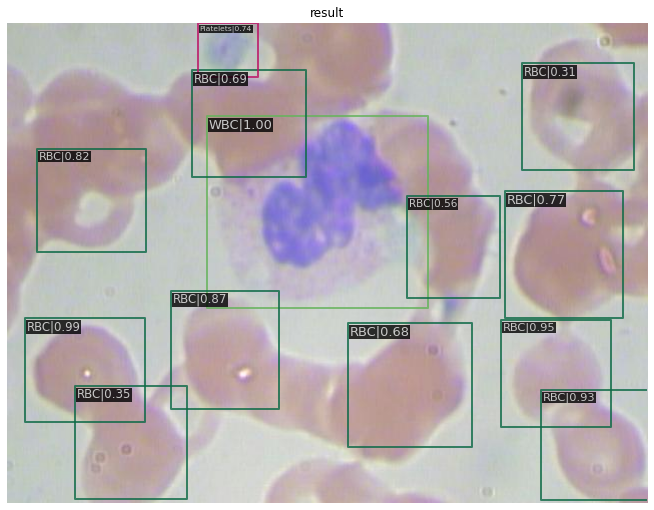

In [30]:
import cv2
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

img = cv2.imread('BCCD_Dataset/BCCD/JPEGImages/BloodImage_00007.jpg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [1]:
### 아래는 런타임 다시 시작 후 실행

from mmcv import Config
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset
from mmdet.apis import set_random_seed

@DATASETS.register_module(force=True)
class BCCDDataset(CocoDataset):
  CLASSES = ('WBC', 'RBC', 'Platelets') 

config_file = '../mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '../mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

cfg = Config.fromfile(config_file)

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'BCCDDataset'
cfg.data_root = 'BCCD_Dataset/BCCD/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'BCCDDataset'
cfg.data.train.data_root = 'BCCD_Dataset/BCCD/'
cfg.data.train.ann_file = 'train.json'
cfg.data.train.img_prefix = 'JPEGImages'

cfg.data.val.type = 'BCCDDataset'
cfg.data.val.data_root = 'BCCD_Dataset/BCCD/'
cfg.data.val.ann_file = 'val.json'
cfg.data.val.img_prefix = 'JPEGImages'

cfg.data.test.type = 'BCCDDataset'
cfg.data.test.data_root = 'BCCD_Dataset/BCCD/'
cfg.data.test.ann_file = 'test.json'
cfg.data.test.img_prefix = 'JPEGImages'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 3
# pretrained 모델
cfg.load_from = '../mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
cfg.evaluation.metric = 'bbox'
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

# bug(?)로 인해 test용 dataset evaluation 시 1로 설정. data loader에서 GPU갯수별 Batch size 임. 
cfg.data.samples_per_gpu = 2

# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [31]:
!mkdir -p show_test_output

In [32]:
cfg.dump('tutorial_exps/bccd_faster_rcnn_conf.py')

In [2]:
# tools/test.py 는 colab에서 제대로 동작하지 않음. 

!python ../mmdetection/tools/test.py tutorial_exps/bccd_faster_rcnn_conf.py tutorial_exps/epoch_12.pth \
--eval 'bbox' \
--show-dir show_test_output

Traceback (most recent call last):
  File "/home/seokjong/DL/Stoney_DLCV/DLCV_git/ch_6/../mmdetection/tools/test.py", line 8, in <module>
    import mmcv
ModuleNotFoundError: No module named 'mmcv'
